In [1]:
from python.read_pics import *
import os

In [2]:
files = []
for name in os.listdir("data"):
    if name.endswith(".bin"):
        files.append(name)

In [3]:
import sys
import numpy as np
from matplotlib import pyplot

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from sklearn.model_selection import train_test_split

In [4]:
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy

    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.show()
    pyplot.close()

In [5]:
labels = ['NOKEY', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B' ,'C', 'D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','CTRL','ENTER','SHIFT','SPACE','SUPPR']

len_labels = len(labels)

input_set = []
result_set = []
index = 0

for label in labels:
    pics, info = get_pics_from_file('data/pics_' + label + '.bin')
    input_set = input_set + pics[0:6963]
    tmp = [0] * len_labels
    tmp[index] = 1
    index += 1
    #for i in range(info["nb_trames"] - 1):
    for i in range(6963):
        result_set.append(tmp)

input_set = np.array(input_set)
result_set = np.array(result_set)

Ouverture du fichier de pics data/pics_NOKEY.bin
Nb pics par trame: 17
Frequence d'echantillonnage: 625.0 kHz
Frequence trame: 315.0 Hz
Frequence pic: 50.0 kHz
Facteur de normalisation: 0.05
Nb trames: 12802
Ouverture du fichier de pics data/pics_0.bin
Nb pics par trame: 17
Frequence d'echantillonnage: 625.0 kHz
Frequence trame: 315.0 Hz
Frequence pic: 50.0 kHz
Facteur de normalisation: 0.05
Nb trames: 8701
Ouverture du fichier de pics data/pics_1.bin
Nb pics par trame: 17
Frequence d'echantillonnage: 625.0 kHz
Frequence trame: 315.0 Hz
Frequence pic: 50.0 kHz
Facteur de normalisation: 0.05
Nb trames: 8390
Ouverture du fichier de pics data/pics_2.bin
Nb pics par trame: 17
Frequence d'echantillonnage: 625.0 kHz
Frequence trame: 315.0 Hz
Frequence pic: 50.0 kHz
Facteur de normalisation: 0.05
Nb trames: 8367
Ouverture du fichier de pics data/pics_3.bin
Nb pics par trame: 17
Frequence d'echantillonnage: 625.0 kHz
Frequence trame: 315.0 Hz
Frequence pic: 50.0 kHz
Facteur de normalisation: 0

In [13]:
es_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3)

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    es_callback,
]
opt = SGD(lr=0.1, momentum=0.9)
input_train, input_test, output_train, output_test = train_test_split(input_set, result_set, test_size=0.33)


n_features = input_train.shape[1]


model = Sequential()
model.add(Dense(17, activation='relu', input_shape=(n_features,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(42, activation='sigmoid'))


model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])


history = model.fit(input_train, output_train, epochs=100, batch_size=32, verbose=1, validation_data=(input_test, output_test), callbacks=callbacks)

model.save("weight.h5")


Epoch 1/100
6124/6124 [==============================] - 25s 4ms/step - loss: 0.1016 - accuracy: 0.2083 - val_loss: 0.0601 - val_accuracy: 0.3888
Epoch 2/100
6124/6124 [==============================] - 23s 4ms/step - loss: 0.0573 - accuracy: 0.4113 - val_loss: 0.0512 - val_accuracy: 0.4539
Epoch 3/100
6124/6124 [==============================] - 27s 4ms/step - loss: 0.0500 - accuracy: 0.4641 - val_loss: 0.0472 - val_accuracy: 0.4811
Epoch 4/100
6124/6124 [==============================] - 23s 4ms/step - loss: 0.0466 - accuracy: 0.4865 - val_loss: 0.0450 - val_accuracy: 0.5003
Epoch 5/100
6124/6124 [==============================] - 27s 4ms/step - loss: 0.0446 - accuracy: 0.5024 - val_loss: 0.0438 - val_accuracy: 0.5065
Epoch 6/100
6124/6124 [==============================] - 23s 4ms/step - loss: 0.0435 - accuracy: 0.5106 - val_loss: 0.0429 - val_accuracy: 0.5150
Epoch 7/100
6124/6124 [==============================] - 23s 4ms/step - loss: 0.0427 - accuracy: 0.5182 - val_loss: 0.0422 -

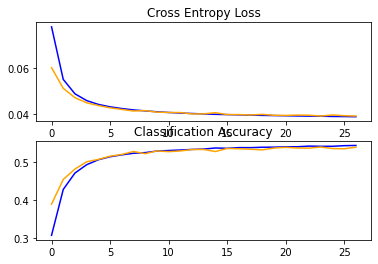

In [14]:
summarize_diagnostics(history)

In [15]:
def __predict(model, frame):
    array = tf.expand_dims(frame, 0)

    predictions = model.predict_on_batch(array)
    return predictions

In [16]:
def debrief(predictions):
    index = np.argmax(predictions)
    return labels[index], index

In [20]:
def keylogger():
    
    model = tf.keras.models.load_model("weight.h5")
    model.compile(
        optimizer=opt,
        loss="binary_crossentropy",
        metrics=["accuracy"])
    
    frames, info = get_pics_from_file('pics_LOGINMDP.bin')
    histo = [0 for j in range(42)]
    result = []

    for i in range(info["nb_trames"] - 1):
        __predict(model, frames[i])
        _, index = debrief(__predict(model, frames[i]))
        histo[index] += 1
        if i % 33 == 0:
            if result == [] or result[-1] != labels[np.argmax(histo)]:
                m = np.argmax(histo)
                result.append(labels[m])
            histo = [0 for j in range(42)]
    return result

In [21]:
r = keylogger()

Ouverture du fichier de pics pics_LOGINMDP.bin
Nb pics par trame: 17
Frequence d'echantillonnage: 625.0 kHz
Frequence trame: 315.0 Hz
Frequence pic: 50.0 kHz
Facteur de normalisation: 0.05
Nb trames: 11102


In [22]:
r

['NOKEY',
 'CTRL',
 'NOKEY',
 'SHIFT',
 'I',
 'SHIFT',
 'NOKEY',
 'H',
 'NOKEY',
 'A',
 'NOKEY',
 'C',
 'NOKEY',
 'K',
 'NOKEY',
 'A',
 'NOKEY',
 'T',
 'NOKEY',
 'O',
 'NOKEY',
 'N',
 'NOKEY',
 '3',
 '1',
 'NOKEY',
 '0',
 'SUPPR',
 'NOKEY',
 '1',
 '3',
 'NOKEY',
 '1',
 'NOKEY',
 'ENTER',
 'NOKEY']